# Calculating PMFs with AWH in GROMACS <a id='another_cell'></a>
Here we learn how to calculate the potential of mean force
(PMF) along a reaction coordinate (RC) using the accelerated weight
histogram method (AWH) in GROMACS.  We will go through both how to set
up the input files needed, as well as how to extract and analyze the
output after having run the simulation. For more information about
the AWH method itself and how it can be used we refer to \cite{}[TODO how cite?].
What you need to know right now is that AWH applies a time-dependent bias
potential along the chosen RC, which is tuned during the simulation
such that it "flattens" the barriers in the PMF to improve sampling along the RC.
With better sampling, the PMF can be calculated more accurately than using unbiased MD. [TODO Movie/figure?]

*Author: Viveca Lindahl   
Email: vivecal@kth.se*

## The case study: DNA base pair opening
We will calculate a PMF for opening a DNA base
pair. The DNA double helix is a very stable structure. Opening a base pair
requires breaking hydrogen bonds between the bases and crossing a high free energy
barrier.  That's why we need to enhance the sampling by applying a bias!
<img src="figs/dna-helix.png" alt="dna" style="height: 300px;"/>
As our RC we use the distance between the two atoms forming the central hydrogen-bond the two bases in a pair. Let's have a look at the system and the reaction coordinate using VMD. The `-e` flag below tells VMD to excute the commands that are in the following tcl-script. These commands change how the system is visually represented. For instance, we have hidden all the water to better see the DNA itself, and we have put punchy colors on the atoms defining the RC of our target base pair. Now run this and VMD should pop up:

In [7]:
!vmd visualization/dna-centered.gro -e visualization/representation.tcl

OSError: Background processes not supported.

Rotate the structure and look for the two (nitrogen) atoms in green. The distance between these will serve as our RC for that base pair.

## The MD parameter (.mdp) file 
We'll assume we have already built and equilibrated the system, so we are almost ready to go. To use AWH we basically just need to add some extra parameters in the mdp file. Go to and check out the directory that has all the run files of our first AWH example:

In [8]:
!pwd
%cd awh-1d
!ls -l

/Users/viveca/presentations/awh-tutorial/dna-base-pair-opening/awh-1d
[Errno 2] No such file or directory: 'awh-1d'
/Users/viveca/presentations/awh-tutorial/dna-base-pair-opening/awh-1d
total 196
lrwxr-xr-x   1 viveca staff     31 May 30 11:58 amber99bsc1.ff -> ../template-npt/amber99bsc1.ff/
lrwxr-xr-x   1 viveca staff     24 May 30 11:58 conf.gro -> ../template-npt/conf.gro
drwxr-xr-x 162 viveca staff   5508 May 30 11:58 data
-rw-r--r--   1 viveca staff   3005 May 30 11:58 grompp.mdp
-rw-r--r--   1 viveca staff 181632 May 30 11:58 index.ndx
lrwxr-xr-x   1 viveca staff     25 May 30 11:58 topol.top -> ../template-npt/topol.top


In [10]:
!pwd

/Users/viveca/presentations/awh-tutorial/dna-base-pair-opening/awh-1d


Find the differences between this mdp file for AWH and an mdp file for a vanilla MD simulation:

In [11]:
!diff ../template-npt/grompp.mdp grompp.mdp

3c3
< nsteps                   = 25000000
---
> nsteps                   = 100000000
30c30
< gen-vel                  = yes
---
> gen-vel                  = no
35a36,59
> 
> pull                     = yes                 ; The reaction coordinate (RC) is defined using pull coordinates.
> pull-ngroups             = 2                   ; The number of atom groups needed to define the pull coordinate.
> pull-ncoords             = 1                   ; Number of pull coordinates.
> pull-nstxout             = 5000                ; Step interval to output the coordinate values to the pullx.xvg file.
> pull-nstfout             = 0                   ; Step interval to output the applied force, skip this output here.
> 					       
> pull-group1-name         = base_N1orN3         ; Name of pull group 1 corresponding to an entry in an index file.
> pull-group2-name         = partner_N1orN3      ; Same, but for group 2.
> 					       
> pull-coord1-groups       = 1 2                 ; Which group

Here '<' refers to the content of the first argument to `diff` (the NPT mdp) and '>' to the second (AWH mdp). E.g., we increased the number of steps (`nsteps`) for AWH. The more relevant parameters are the ones prefixed `pull` and `awh`. What do these parameters mean? Generally, google "gromacs documentation" to find out, but the comments in the mdp file should be enough here.

## The index (.ndx) file
The .mdp file now depends on some definitions of atom groups; we need to have an index file for these. Here our groups are as simple as they get: each group contains a single nitrogen atom. But don't get tempted to edit an index file manually! The traditional tool to use is `gmx make_ndx` and a more general and powerful tool is `gmx select`. We focus on AWH here and provide the index file, and leave the index file generation as an [exercise](#sec:make-index). Double-check that the groups we saw in the mdp file are actually defined in the index file:


In [12]:
!grep -A 1  N1orN3  index.ndx  # '-A 1' to show also 1 line after the match 

[ base_N1orN3 ]
 338 
--
[ partner_N1orN3 ]
 936 


One atom per group looks right. In a real study, a better check would be to visualize these atom indices (e.g. with VMD).

## Starting and analyzing the simulation
Now generate the tpr as usual with `grompp` (assuming default naming of input files grompp.mdp, conf.gro, topol.top, index.ndx) 

In [18]:
!gmx grompp -n -quiet

Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Setting the AWH bias MC random seed to 1326876231
Setting the LD random seed to 403339548
Generated 2485 of the 2485 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2485 of the 2485 1-4 parameter combinations
Excluding 3 bonded neighbours molecule type 'DNA_chain_A'
turning H bonds into constraints...
Excluding 3 bonded neighbours molecule type 'DNA_chain_B'
turning H bonds into constraints...
Excluding 2 bonded neighbours molecule type 'SOL'
turning H bonds into constraints...
Excluding 1 bonded neighbours molecule type 'NA'
turning H bonds into constraints...
Removing all charge groups because cutoff-scheme=Verlet
Pull group 1 'base_N1orN3' has 1 atoms
Pull group 2 'partner_N1orN3' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 19587.00
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.034 nm, buffer 

Note that the values of the pull coordinate values in the provided .gro file are printed by grompp. Does it look reasonable? We now assume we have run a simulation. Some information related to the AWH initial convergence can be found in the `mdrun` log file.

In [24]:
!grep 'covering' data/md.log
!grep 'out of the' data/md.log

awh1: covering at t = 1243.8 ps. Decreased the update size.
awh1: covering at t = 1530 ps. Decreased the update size.
awh1: out of the initial stage at t = 1530.


In the intial stage, the free energy (and bias) update size is kept constant *during* each covering(=transition) across the sampling interval, and decreased in a stepwise manner after each covering.  After exiting the initial stage, the free energy update size will decrease steadily with time. The initial stage is a type of "burn-in" process that improves robustness of the method. The idea is to first get a quick and rough estimate in the intitial stage, followed by refinement in the final stage. The trajectory of the pull coordinate is found in `pullx.xvg`

In [184]:
import numpy as np
import matplotlib.pyplot as plt

# Function that reads data of an .xvg file
def read_xvg(fname):
    data=[]
    with open(fname) as f: 
        for line in f:
            # Lines with metadata or comments start with #, @
            if not line.startswith(("@","#")):
                data.append(np.array([float(s) for s in line.split()]))
    data = np.vstack(data)
    return data

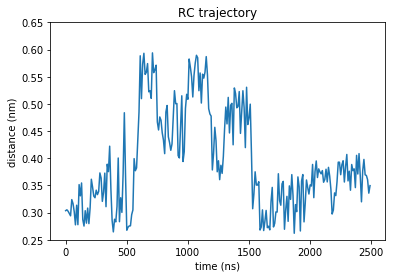

In [185]:
# Read pullx.xvg file and plot a selected part of the trajectory
data = read_xvg("data/pullx.xvg")
t, x = data[:,0], data[:,1]
tend =2500
selection = np.where(t<tend)
plt.plot(t[selection], x[selection])
ax = plt.gca()
# Tweak
plt.xlabel("time (ns)")
plt.ylabel("distance (nm)");
plt.ylim([0.25, 0.65])
plt.title('RC trajectory');

#texit = 1530
#plt.plot([texit,texit],[0,1])

Verify that the covering times correspond to the transition times in the trajectory (assuming the `pullx.xvg` output is frequent enough). Always check the RC trajectory and make sure that you are observing at least a few transitions after the initial stage. If not, you need to simulate longer or you might have an RC issue.

Data directly related to AWH is extracted using `gmx awh`. The data is stored in the energy file, `ener.edr`. The output is `awh_t<time>.xvg`; there will be one file for each AWH output time, or less if you use the `-skip` flag. The `-more` flag tells `gmx awh` to more than the PMF from the AWH files, e.g. histograms. The default gmx units of energy is kJ/mol, but with the flag `-kT` we get units of kT.

In [165]:
!gmx awh -quiet -s topol.tpr -f data/ener.edr -more -kt

Opened data/ener.edr as single precision energy file
Reading file topol.tpr, VERSION 2018.2-dev-20180410-f2c9e7785-dirty-unknown (single precision)
Reading energy frame      0 time    0.000         
Back Off! I just backed up awh_t0.xvg to ./#awh_t0.xvg.5#
Reading energy frame      1 time  100.000         
Back Off! I just backed up awh_t100.xvg to ./#awh_t100.xvg.5#
Reading energy frame      2 time  200.000         
Back Off! I just backed up awh_t200.xvg to ./#awh_t200.xvg.5#
Reading energy frame      3 time  300.000         
Back Off! I just backed up awh_t300.xvg to ./#awh_t300.xvg.5#
Reading energy frame      4 time  400.000         
Back Off! I just backed up awh_t400.xvg to ./#awh_t400.xvg.5#
Reading energy frame      5 time  500.000         
Back Off! I just backed up awh_t500.xvg to ./#awh_t500.xvg.5#
Reading energy frame      6 time  600.000         
Back Off! I just backed up awh_t600.xvg to ./#awh_t600.xvg.5#
Reading energy frame      7 time  700.000         
Back Off! I ju


Back Off! I just backed up awh_t11500.xvg to ./#awh_t11500.xvg.5#

Back Off! I just backed up awh_t11600.xvg to ./#awh_t11600.xvg.5#

Back Off! I just backed up awh_t11700.xvg to ./#awh_t11700.xvg.5#

Back Off! I just backed up awh_t11800.xvg to ./#awh_t11800.xvg.5#

Back Off! I just backed up awh_t11900.xvg to ./#awh_t11900.xvg.5#
Reading energy frame    120 time 12000.000         
Back Off! I just backed up awh_t12000.xvg to ./#awh_t12000.xvg.5#

Back Off! I just backed up awh_t12100.xvg to ./#awh_t12100.xvg.5#

Back Off! I just backed up awh_t12200.xvg to ./#awh_t12200.xvg.5#

Back Off! I just backed up awh_t12300.xvg to ./#awh_t12300.xvg.5#

Back Off! I just backed up awh_t12400.xvg to ./#awh_t12400.xvg.5#

Back Off! I just backed up awh_t12500.xvg to ./#awh_t12500.xvg.5#

Back Off! I just backed up awh_t12600.xvg to ./#awh_t12600.xvg.5#

Back Off! I just backed up awh_t12700.xvg to ./#awh_t12700.xvg.5#

Back Off! I just backed up awh_t12800.xvg to ./#awh_t12800.xvg.5#

Back Off! 


Back Off! I just backed up awh_t24200.xvg to ./#awh_t24200.xvg.5#

Back Off! I just backed up awh_t24300.xvg to ./#awh_t24300.xvg.5#

Back Off! I just backed up awh_t24400.xvg to ./#awh_t24400.xvg.5#

Back Off! I just backed up awh_t24500.xvg to ./#awh_t24500.xvg.5#

Back Off! I just backed up awh_t24600.xvg to ./#awh_t24600.xvg.5#

Back Off! I just backed up awh_t24700.xvg to ./#awh_t24700.xvg.5#

Back Off! I just backed up awh_t24800.xvg to ./#awh_t24800.xvg.5#

Back Off! I just backed up awh_t24900.xvg to ./#awh_t24900.xvg.5#

Back Off! I just backed up awh_t25000.xvg to ./#awh_t25000.xvg.5#

Back Off! I just backed up awh_t25100.xvg to ./#awh_t25100.xvg.5#

Back Off! I just backed up awh_t25200.xvg to ./#awh_t25200.xvg.5#

Back Off! I just backed up awh_t25300.xvg to ./#awh_t25300.xvg.5#

Back Off! I just backed up awh_t25400.xvg to ./#awh_t25400.xvg.5#

Back Off! I just backed up awh_t25500.xvg to ./#awh_t25500.xvg.5#

Back Off! I just backed up awh_t25600.xvg to ./#awh_t25600.xv


Back Off! I just backed up awh_t40300.xvg to ./#awh_t40300.xvg.5#

Back Off! I just backed up awh_t40400.xvg to ./#awh_t40400.xvg.5#

Back Off! I just backed up awh_t40500.xvg to ./#awh_t40500.xvg.5#

Back Off! I just backed up awh_t40600.xvg to ./#awh_t40600.xvg.5#

Back Off! I just backed up awh_t40700.xvg to ./#awh_t40700.xvg.5#

Back Off! I just backed up awh_t40800.xvg to ./#awh_t40800.xvg.5#

Back Off! I just backed up awh_t40900.xvg to ./#awh_t40900.xvg.5#

Back Off! I just backed up awh_t41000.xvg to ./#awh_t41000.xvg.5#

Back Off! I just backed up awh_t41100.xvg to ./#awh_t41100.xvg.5#

Back Off! I just backed up awh_t41200.xvg to ./#awh_t41200.xvg.5#

Back Off! I just backed up awh_t41300.xvg to ./#awh_t41300.xvg.5#

Back Off! I just backed up awh_t41400.xvg to ./#awh_t41400.xvg.5#

Back Off! I just backed up awh_t41500.xvg to ./#awh_t41500.xvg.5#

Back Off! I just backed up awh_t41600.xvg to ./#awh_t41600.xvg.5#

Back Off! I just backed up awh_t41700.xvg to ./#awh_t41700.xv


Back Off! I just backed up awh_t54100.xvg to ./#awh_t54100.xvg.5#

Back Off! I just backed up awh_t54200.xvg to ./#awh_t54200.xvg.5#

Back Off! I just backed up awh_t54300.xvg to ./#awh_t54300.xvg.5#

Back Off! I just backed up awh_t54400.xvg to ./#awh_t54400.xvg.5#

Back Off! I just backed up awh_t54500.xvg to ./#awh_t54500.xvg.5#

Back Off! I just backed up awh_t54600.xvg to ./#awh_t54600.xvg.5#

Back Off! I just backed up awh_t54700.xvg to ./#awh_t54700.xvg.5#

Back Off! I just backed up awh_t54800.xvg to ./#awh_t54800.xvg.5#

Back Off! I just backed up awh_t54900.xvg to ./#awh_t54900.xvg.5#

Back Off! I just backed up awh_t55000.xvg to ./#awh_t55000.xvg.5#

Back Off! I just backed up awh_t55100.xvg to ./#awh_t55100.xvg.5#

Back Off! I just backed up awh_t55200.xvg to ./#awh_t55200.xvg.5#

Back Off! I just backed up awh_t55300.xvg to ./#awh_t55300.xvg.5#

Back Off! I just backed up awh_t55400.xvg to ./#awh_t55400.xvg.5#

Back Off! I just backed up awh_t55500.xvg to ./#awh_t55500.xv


Back Off! I just backed up awh_t66400.xvg to ./#awh_t66400.xvg.5#

Back Off! I just backed up awh_t66500.xvg to ./#awh_t66500.xvg.5#

Back Off! I just backed up awh_t66600.xvg to ./#awh_t66600.xvg.5#

Back Off! I just backed up awh_t66700.xvg to ./#awh_t66700.xvg.5#

Back Off! I just backed up awh_t66800.xvg to ./#awh_t66800.xvg.5#

Back Off! I just backed up awh_t66900.xvg to ./#awh_t66900.xvg.5#

Back Off! I just backed up awh_t67000.xvg to ./#awh_t67000.xvg.5#

Back Off! I just backed up awh_t67100.xvg to ./#awh_t67100.xvg.5#

Back Off! I just backed up awh_t67200.xvg to ./#awh_t67200.xvg.5#

Back Off! I just backed up awh_t67300.xvg to ./#awh_t67300.xvg.5#

Back Off! I just backed up awh_t67400.xvg to ./#awh_t67400.xvg.5#

Back Off! I just backed up awh_t67500.xvg to ./#awh_t67500.xvg.5#

Back Off! I just backed up awh_t67600.xvg to ./#awh_t67600.xvg.5#

Back Off! I just backed up awh_t67700.xvg to ./#awh_t67700.xvg.5#

Back Off! I just backed up awh_t67800.xvg to ./#awh_t67800.xv


Back Off! I just backed up awh_t81800.xvg to ./#awh_t81800.xvg.5#

Back Off! I just backed up awh_t81900.xvg to ./#awh_t81900.xvg.5#

Back Off! I just backed up awh_t82000.xvg to ./#awh_t82000.xvg.5#

Back Off! I just backed up awh_t82100.xvg to ./#awh_t82100.xvg.5#

Back Off! I just backed up awh_t82200.xvg to ./#awh_t82200.xvg.5#

Back Off! I just backed up awh_t82300.xvg to ./#awh_t82300.xvg.5#

Back Off! I just backed up awh_t82400.xvg to ./#awh_t82400.xvg.5#

Back Off! I just backed up awh_t82500.xvg to ./#awh_t82500.xvg.5#

Back Off! I just backed up awh_t82600.xvg to ./#awh_t82600.xvg.5#

Back Off! I just backed up awh_t82700.xvg to ./#awh_t82700.xvg.5#

Back Off! I just backed up awh_t82800.xvg to ./#awh_t82800.xvg.5#

Back Off! I just backed up awh_t82900.xvg to ./#awh_t82900.xvg.5#

Back Off! I just backed up awh_t83000.xvg to ./#awh_t83000.xvg.5#

Back Off! I just backed up awh_t83100.xvg to ./#awh_t83100.xvg.5#

Back Off! I just backed up awh_t83200.xvg to ./#awh_t83200.xv


Back Off! I just backed up awh_t96500.xvg to ./#awh_t96500.xvg.5#

Back Off! I just backed up awh_t96600.xvg to ./#awh_t96600.xvg.5#

Back Off! I just backed up awh_t96700.xvg to ./#awh_t96700.xvg.5#

Back Off! I just backed up awh_t96800.xvg to ./#awh_t96800.xvg.5#

Back Off! I just backed up awh_t96900.xvg to ./#awh_t96900.xvg.5#

Back Off! I just backed up awh_t97000.xvg to ./#awh_t97000.xvg.5#

Back Off! I just backed up awh_t97100.xvg to ./#awh_t97100.xvg.5#

Back Off! I just backed up awh_t97200.xvg to ./#awh_t97200.xvg.5#

Back Off! I just backed up awh_t97300.xvg to ./#awh_t97300.xvg.5#

Back Off! I just backed up awh_t97400.xvg to ./#awh_t97400.xvg.5#

Back Off! I just backed up awh_t97500.xvg to ./#awh_t97500.xvg.5#

Back Off! I just backed up awh_t97600.xvg to ./#awh_t97600.xvg.5#

Back Off! I just backed up awh_t97700.xvg to ./#awh_t97700.xvg.5#

Back Off! I just backed up awh_t97800.xvg to ./#awh_t97800.xvg.5#

Back Off! I just backed up awh_t97900.xvg to ./#awh_t97900.xv


Back Off! I just backed up awh_t110200.xvg to ./#awh_t110200.xvg.5#

Back Off! I just backed up awh_t110300.xvg to ./#awh_t110300.xvg.5#

Back Off! I just backed up awh_t110400.xvg to ./#awh_t110400.xvg.5#

Back Off! I just backed up awh_t110500.xvg to ./#awh_t110500.xvg.5#

Back Off! I just backed up awh_t110600.xvg to ./#awh_t110600.xvg.5#

Back Off! I just backed up awh_t110700.xvg to ./#awh_t110700.xvg.5#

Back Off! I just backed up awh_t110800.xvg to ./#awh_t110800.xvg.5#

Back Off! I just backed up awh_t110900.xvg to ./#awh_t110900.xvg.5#

Back Off! I just backed up awh_t111000.xvg to ./#awh_t111000.xvg.5#

Back Off! I just backed up awh_t111100.xvg to ./#awh_t111100.xvg.5#

Back Off! I just backed up awh_t111200.xvg to ./#awh_t111200.xvg.5#

Back Off! I just backed up awh_t111300.xvg to ./#awh_t111300.xvg.5#

Back Off! I just backed up awh_t111400.xvg to ./#awh_t111400.xvg.5#

Back Off! I just backed up awh_t111500.xvg to ./#awh_t111500.xvg.5#

Back Off! I just backed up awh_t1


Back Off! I just backed up awh_t123000.xvg to ./#awh_t123000.xvg.5#

Back Off! I just backed up awh_t123100.xvg to ./#awh_t123100.xvg.5#

Back Off! I just backed up awh_t123200.xvg to ./#awh_t123200.xvg.5#

Back Off! I just backed up awh_t123300.xvg to ./#awh_t123300.xvg.5#

Back Off! I just backed up awh_t123400.xvg to ./#awh_t123400.xvg.5#

Back Off! I just backed up awh_t123500.xvg to ./#awh_t123500.xvg.5#

Back Off! I just backed up awh_t123600.xvg to ./#awh_t123600.xvg.5#

Back Off! I just backed up awh_t123700.xvg to ./#awh_t123700.xvg.5#

Back Off! I just backed up awh_t123800.xvg to ./#awh_t123800.xvg.5#

Back Off! I just backed up awh_t123900.xvg to ./#awh_t123900.xvg.5#

Back Off! I just backed up awh_t124000.xvg to ./#awh_t124000.xvg.5#

Back Off! I just backed up awh_t124100.xvg to ./#awh_t124100.xvg.5#

Back Off! I just backed up awh_t124200.xvg to ./#awh_t124200.xvg.5#

Back Off! I just backed up awh_t124300.xvg to ./#awh_t124300.xvg.5#

Back Off! I just backed up awh_t1


Back Off! I just backed up awh_t136600.xvg to ./#awh_t136600.xvg.5#

Back Off! I just backed up awh_t136700.xvg to ./#awh_t136700.xvg.5#

Back Off! I just backed up awh_t136800.xvg to ./#awh_t136800.xvg.5#

Back Off! I just backed up awh_t136900.xvg to ./#awh_t136900.xvg.5#

Back Off! I just backed up awh_t137000.xvg to ./#awh_t137000.xvg.5#

Back Off! I just backed up awh_t137100.xvg to ./#awh_t137100.xvg.5#

Back Off! I just backed up awh_t137200.xvg to ./#awh_t137200.xvg.5#

Back Off! I just backed up awh_t137300.xvg to ./#awh_t137300.xvg.5#

Back Off! I just backed up awh_t137400.xvg to ./#awh_t137400.xvg.5#

Back Off! I just backed up awh_t137500.xvg to ./#awh_t137500.xvg.5#

Back Off! I just backed up awh_t137600.xvg to ./#awh_t137600.xvg.5#

Back Off! I just backed up awh_t137700.xvg to ./#awh_t137700.xvg.5#

Back Off! I just backed up awh_t137800.xvg to ./#awh_t137800.xvg.5#

Back Off! I just backed up awh_t137900.xvg to ./#awh_t137900.xvg.5#

Back Off! I just backed up awh_t1


Back Off! I just backed up awh_t152200.xvg to ./#awh_t152200.xvg.5#

Back Off! I just backed up awh_t152300.xvg to ./#awh_t152300.xvg.5#

Back Off! I just backed up awh_t152400.xvg to ./#awh_t152400.xvg.5#

Back Off! I just backed up awh_t152500.xvg to ./#awh_t152500.xvg.5#

Back Off! I just backed up awh_t152600.xvg to ./#awh_t152600.xvg.5#

Back Off! I just backed up awh_t152700.xvg to ./#awh_t152700.xvg.5#

Back Off! I just backed up awh_t152800.xvg to ./#awh_t152800.xvg.5#

Back Off! I just backed up awh_t152900.xvg to ./#awh_t152900.xvg.5#

Back Off! I just backed up awh_t153000.xvg to ./#awh_t153000.xvg.5#

Back Off! I just backed up awh_t153100.xvg to ./#awh_t153100.xvg.5#

Back Off! I just backed up awh_t153200.xvg to ./#awh_t153200.xvg.5#

Back Off! I just backed up awh_t153300.xvg to ./#awh_t153300.xvg.5#

Back Off! I just backed up awh_t153400.xvg to ./#awh_t153400.xvg.5#

Back Off! I just backed up awh_t153500.xvg to ./#awh_t153500.xvg.5#

Back Off! I just backed up awh_t1


Back Off! I just backed up awh_t165900.xvg to ./#awh_t165900.xvg.5#

Back Off! I just backed up awh_t166000.xvg to ./#awh_t166000.xvg.5#

Back Off! I just backed up awh_t166100.xvg to ./#awh_t166100.xvg.5#

Back Off! I just backed up awh_t166200.xvg to ./#awh_t166200.xvg.5#

Back Off! I just backed up awh_t166300.xvg to ./#awh_t166300.xvg.5#

Back Off! I just backed up awh_t166400.xvg to ./#awh_t166400.xvg.5#

Back Off! I just backed up awh_t166500.xvg to ./#awh_t166500.xvg.5#

Back Off! I just backed up awh_t166600.xvg to ./#awh_t166600.xvg.5#

Back Off! I just backed up awh_t166700.xvg to ./#awh_t166700.xvg.5#

Back Off! I just backed up awh_t166800.xvg to ./#awh_t166800.xvg.5#

Back Off! I just backed up awh_t166900.xvg to ./#awh_t166900.xvg.5#

Back Off! I just backed up awh_t167000.xvg to ./#awh_t167000.xvg.5#

Back Off! I just backed up awh_t167100.xvg to ./#awh_t167100.xvg.5#

Back Off! I just backed up awh_t167200.xvg to ./#awh_t167200.xvg.5#

Back Off! I just backed up awh_t1


Back Off! I just backed up awh_t181000.xvg to ./#awh_t181000.xvg.5#

Back Off! I just backed up awh_t181100.xvg to ./#awh_t181100.xvg.5#

Back Off! I just backed up awh_t181200.xvg to ./#awh_t181200.xvg.5#

Back Off! I just backed up awh_t181300.xvg to ./#awh_t181300.xvg.5#

Back Off! I just backed up awh_t181400.xvg to ./#awh_t181400.xvg.5#

Back Off! I just backed up awh_t181500.xvg to ./#awh_t181500.xvg.5#

Back Off! I just backed up awh_t181600.xvg to ./#awh_t181600.xvg.5#

Back Off! I just backed up awh_t181700.xvg to ./#awh_t181700.xvg.5#

Back Off! I just backed up awh_t181800.xvg to ./#awh_t181800.xvg.5#

Back Off! I just backed up awh_t181900.xvg to ./#awh_t181900.xvg.5#

Back Off! I just backed up awh_t182000.xvg to ./#awh_t182000.xvg.5#

Back Off! I just backed up awh_t182100.xvg to ./#awh_t182100.xvg.5#

Back Off! I just backed up awh_t182200.xvg to ./#awh_t182200.xvg.5#

Back Off! I just backed up awh_t182300.xvg to ./#awh_t182300.xvg.5#

Back Off! I just backed up awh_t1


Back Off! I just backed up awh_t194400.xvg to ./#awh_t194400.xvg.5#

Back Off! I just backed up awh_t194500.xvg to ./#awh_t194500.xvg.5#

Back Off! I just backed up awh_t194600.xvg to ./#awh_t194600.xvg.5#

Back Off! I just backed up awh_t194700.xvg to ./#awh_t194700.xvg.5#

Back Off! I just backed up awh_t194800.xvg to ./#awh_t194800.xvg.5#

Back Off! I just backed up awh_t194900.xvg to ./#awh_t194900.xvg.5#

Back Off! I just backed up awh_t195000.xvg to ./#awh_t195000.xvg.5#

Back Off! I just backed up awh_t195100.xvg to ./#awh_t195100.xvg.5#

Back Off! I just backed up awh_t195200.xvg to ./#awh_t195200.xvg.5#

Back Off! I just backed up awh_t195300.xvg to ./#awh_t195300.xvg.5#

Back Off! I just backed up awh_t195400.xvg to ./#awh_t195400.xvg.5#

Back Off! I just backed up awh_t195500.xvg to ./#awh_t195500.xvg.5#

Back Off! I just backed up awh_t195600.xvg to ./#awh_t195600.xvg.5#

Back Off! I just backed up awh_t195700.xvg to ./#awh_t195700.xvg.5#

Back Off! I just backed up awh_t1

For a quick look at the contents of these files we can use the click-friendly plotting tool `xmgrace`, which recognizes xvg files

In [188]:
t=50000 # ps
# -free for nice layout
# -nxy to plot multicolumn data
!xmgrace -free -nxy awh_t{t}.xvg # wait for it... 

The legends in the plot should help understanding what data is being plotted, but here's more:
* *PMF*: the free energy estimate along the RC
* *Coord bias*: the bias acting on the RC
* *Coord distr*: the observed distribution (histogram) of the RC, $\xi(x)$
* *Ref value distr*: weight histogram of reference coordinate value, $\lambda$
* *Target ref value distr*: the target distribution for $\lambda$ (uniform by default)
* Friction metric: a (here unitless) metric for local friction

Sanity checks for the distributions:
* *Coord distr* $\approx$ *Ref value distr*, or the force constant in the mdp file is too weak.
* *Ref value distr* $\approx$ *Target ref value distr*, or we may have a poor bias estimate/need to sample longer.

Let's look closer at the evolution of the PMF.

In [202]:
import re # use regular expressions to find matching strings

# Plot PMFs from AWH xvg files

# A list of all AWH files
fnames = !ls awh_t*xvg

# Extract time of each file
times = [float(re.findall('awh_t(.+?).xvg', fname)[0]) for fname in fnames]

# Sort the files chronologically
fnames = [f for (t,f) in sorted(zip(times, fnames))]
times.sort()
print "Number of files:", len(fnames)
print "Time in between files ", times[1] - times[0], 'ps'
print "Last time", times[-1], 'ps'

Number of files: 2001
Time in between files  100.0 ps
Last time 200000.0 ps


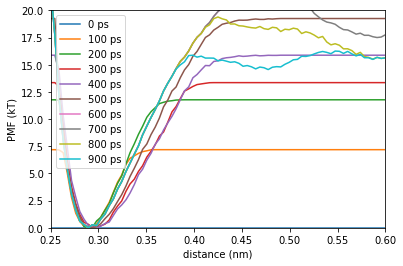

In [203]:
# Plot the PMF from first files/times
labels=[]
istart = 0  # Start plotting this file index
nplot = 10  # Number of files to plot
for fname in fnames[istart:istart+nplot]:
    data=read_xvg(fname)
    labels.append(re.findall('awh_t(.+?).xvg', fname)[0] + ' ps') # use the time as label
    plt.plot(data[:,0], data[:,1])
plt.xlabel('distance (nm)')
plt.ylabel('PMF (kT)')
plt.xlim([0.25,0.60])
plt.ylim([0,20])
plt.legend(labels);

Try increasing the `istart` variable above to see how the PMF estimates are changing less and less over time. *Note*: this convergence does not easily translate into error estimates for the PMF. To get such error bars the simplest is to run multiple (independent) AWH simulations and calculate standard errors from there [add exercise?]

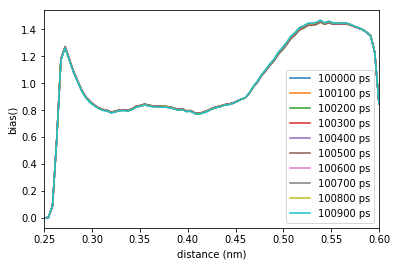

In [180]:
# Plot the histogram from first files/times
labels=[]
istart = 1000  # Start plotting this file index
nplot = 10  # Number of files to plot
for fname in fnames[istart:istart+nplot]:
    data=read_xvg(fname)
    labels.append(re.findall('awh_t(.+?).xvg', fname)[0] + ' ps') # use the time as label
    plt.plot(data[:,0], data[:,3])
plt.xlabel('distance (nm)')
plt.ylabel('bias()')
plt.xlim([0.25,0.60])
#plt.ylim([0,20])
plt.legend(labels)

TH

In [29]:
a=10
!ls {a}

ls: cannot access 10: No such file or directory


## Extracurricular: effect of changing the force constant

## Extracurricular: effect of changing the diffusion parameter

## Extracurricular: making an index file  with `gmx select`
<a id='sec:make-index'></a>

but here I'll instead show how to use the flashier and more general tool `gmx select`. Learn about it using `gmx select -h`, as for any gmx command. Alternatively, the same information canbe found in the online GROMACS docs that you hopefully found above. HereFor making and index file we need to provide either a selection file (flag `-sf`) or a selection string (`-select`)

In [ ]:
!echo hello

In [7]:
%pwd
%ls -l

total 32
drwxr-xr-x 2 viveca ipausers  4096 May 25 14:43 awh-1d/
-rw-r--r-- 1 viveca ipausers 14273 May 25 14:52 awh-tutorial.ipynb
drwxr-xr-x 2 viveca ipausers  4096 May 22 17:58 figs/
drwxr-xr-x 3 viveca ipausers  4096 May 23 10:21 template-npt/
drwxr-xr-x 2 viveca ipausers  4096 May 23 17:33 visualization/
